In [427]:
# Import required libraries
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from config import db_config
from plotly.subplots import make_subplots
import warnings
import ipywidgets as widgets
from IPython.display import display
from dash import Dash, html, dcc, Input, Output
import dash_bootstrap_components as dbc


# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
warnings.filterwarnings('ignore')

# Set plotting style (using default instead of seaborn-v0_8 to avoid crash)
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [428]:
# Establish connection
connection = mysql.connector.connect(
    host=db_config["host"],
    user=db_config["user"],
    password=db_config["password"],
    database=db_config["database"]
)
cursor = connection.cursor()

In [429]:
teams_dict = {
    'team_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 46, 47, 48, 49, 52, 53, 54, 55, 56, 59, 68],
    'team_name': ['New Jersey Devils', 'New York Islanders', 'New York Rangers', 'Philadelphia Flyers', 'Pittsburgh Penguins', 'Boston Bruins', 'Buffalo Sabres', 'Montreal Canadiens', 'Ottawa Senators', 'Toronto Maple Leafs', 'Atlanta Thrashers', 'Carolina Hurricanes', 'Florida Panthers', 'Tampa Bay Lightning', 'Washington Capitals', 'Chicago Blackhawks', 'Detroit Red Wings', 'Nashville Predators', 'St Louis Blues', 'Calgary Flames', 'Colorado Avalanche', 'Edmonton Oilers', 'Vancouver Canucks', 'Anaheim Ducks', 'Dallas Stars', 'Los Angeles Kings', 'Pheonix Coyotes', 'San Jose Sharks', 'Columbus Blue Jackets', 'Minnesota Wild', 'Minnesota North Stars', 'Quebec Nordique', 'Winnipeg Jets (1979)', 'Hartford Whalers', 'Colorado Rockies', 'Oakland Seals', 'Atlanta Flames', 'Kansas City Scouts', 'Cleveland Barons', 'Winnipeg Jets', 'Arizona Coyotes', 'Vegas Golden Knights', 'Seattle Kraken', 'California Golden Seals', 'Utah Hockey Club', 'Utah Mammoth'],
    'team_abbreviation': ['NJD', 'NYI', 'NYR', 'PHI', 'PIT', 'BOS', 'BUF', 'MTL', 'OTT', 'TOR', 'ATL', 'CAR', 'FLA', 'TBL', 'WSH', 'CHI', 'DET', 'NSH', 'STL', 'CGY', 'COL', 'EDM', 'VAN', 'ANA', 'DAL', 'LAK', 'PHX', 'SJS', 'CBJ', 'MIN', 'MNS', 'QUE', 'WIN', 'HFD', 'CLR', 'OAK', 'AFM', 'KCS', 'CLE', 'WPG', 'ARI', 'VGK', 'SEA', 'CGS', 'UTA', 'UTA']
}

In [430]:
cursor.execute('''
    SELECT * FROM players_season
''')

players = cursor.fetchall()

headers = [col[0] for col in cursor.description]    # column names
df = pd.DataFrame(players, columns=headers)

df = df.sort_values(["player_id", "season_id"])

players_df = df.merge(
    df,
    on="player_id",
    suffixes=("_prev", "_curr")
)

#get age from players table
cursor.execute('''
    SELECT player_id, birth_date FROM players
''')

players_birth = cursor.fetchall()

headers = [col[0] for col in cursor.description]    # column names
birth_df = pd.DataFrame(players_birth, columns=headers)

#merge tables on player_id
players_df = players_df.merge(
    birth_df,
    on="player_id",
)




In [431]:
players_df['season_year_prev'] = pd.to_numeric(players_df['season_id_prev'].astype(str).str[:4], errors='coerce')
players_df['season_year_curr'] = pd.to_numeric(players_df['season_id_curr'].astype(str).str[:4], errors='coerce')

# Features from previous season
# assists, ev_goals, ev_points, faceoff_win_pct, game_winning_goals, games_played, goals, ot_goals, penalty_minutes, plus_minus, points_per_game, 
# position_code, pp_goals, pp_points, season_id, sh_goals, sh_points, shooting_percentage, shoots_catches, shots, time_on_ice_per_game
features = [
    "assists_prev", "ev_goals_prev", "ev_points_prev", "game_winning_goals_prev", "games_played_prev", "goals_prev", "ot_goals_prev", "penalty_minutes_prev", "plus_minus_prev", "points_per_game_prev", 
    "pp_goals_prev", "pp_points_prev", "sh_goals_prev", "sh_points_prev", "shooting_percentage_prev", "shots_prev", "time_on_ice_per_game_prev", "season_year_prev", "age_curr"
]



#one-hot encode position_code_prev
#no C because 3 falses means C
pos_dummies = pd.get_dummies(players_df['position_code_prev'], prefix='pos', drop_first=True, dtype=int)
players_df = pd.concat([players_df, pos_dummies], axis=1)

# add dummy names to features (only those new columns)
new_pos_cols = [c for c in pos_dummies.columns]
features += new_pos_cols



# Keep only consecutive seasons
players_df = players_df[players_df['season_year_curr'] == players_df['season_year_prev'] + 1]

#start at season_id_prev as 19971998 to ensure we have prior season data
players_df = players_df[players_df['season_id_prev'] >= 19971998]

#remove any players with less than 20 games played in previous season
players_df = players_df[players_df['games_played_prev'] >= 20]
#remove any players with 0 points per game in previous season
players_df = players_df[players_df['points_per_game_prev'] > 0]


#take birth_date and convert to age at start of current season (assume season starts Oct 1 of season_year_curr), date format YYYY-MM-DD
players_df['birth_date'] = pd.to_datetime(players_df['birth_date'], errors='coerce')
players_df['season_start_date'] = pd.to_datetime(players_df['season_year_curr'].astype(str) + '-10-01', errors='coerce')
players_df['age_curr'] = (players_df['season_start_date'] - players_df['birth_date']).dt.days / 365.25


#add interaction terms goals x shots
players_df["goals_x_shots"] = players_df["goals_prev"] * players_df["shots_prev"]
features.append("goals_x_shots")

#points x time on ice
# changes nothing and has a high correlation with other columns
# players_df["points_x_toi"] = players_df["points_prev"] * players_df["time_on_ice_per_game_prev"]
# features.append("points_x_toi")

#time on ice x shooting percentage
# > 0.05 p value
# players_df["toi_x_shooting_pct"] = players_df["time_on_ice_per_game_prev"] * players_df["shooting_percentage_prev"]
# features.append("toi_x_shooting_pct")

#age x points per game
players_df["age_x_ppg"] = players_df["age_curr"] * players_df["points_per_game_prev"]
features.append("age_x_ppg")




players_df_model = players_df.copy()
#remove any players with 0 points per game in current season
players_df_model = players_df[players_df['points_per_game_curr'] > 0]
#remove any players with less than 20 games played in current season
players_df_model = players_df[players_df['games_played_curr'] >= 20]




In [432]:
#drop features we don't want to use
players_df = players_df.drop(columns=['ev_goals_prev', 'sh_goals_prev', 'sh_points_prev', 'pp_goals_prev', 'season_year_prev', 'ot_goals_prev'])
#remove from features
features.remove('ev_goals_prev')
features.remove('sh_goals_prev')
features.remove('sh_points_prev')
features.remove('pp_goals_prev')
features.remove('season_year_prev')
features.remove('ot_goals_prev')
#plus_minus_prev, goal_prev, pos_L, pos_R
players_df = players_df.drop(columns=['plus_minus_prev', 'goals_prev', 'pos_L', 'pos_R'])
features.remove('plus_minus_prev')
features.remove('goals_prev')
features.remove('pos_L')
features.remove('pos_R')

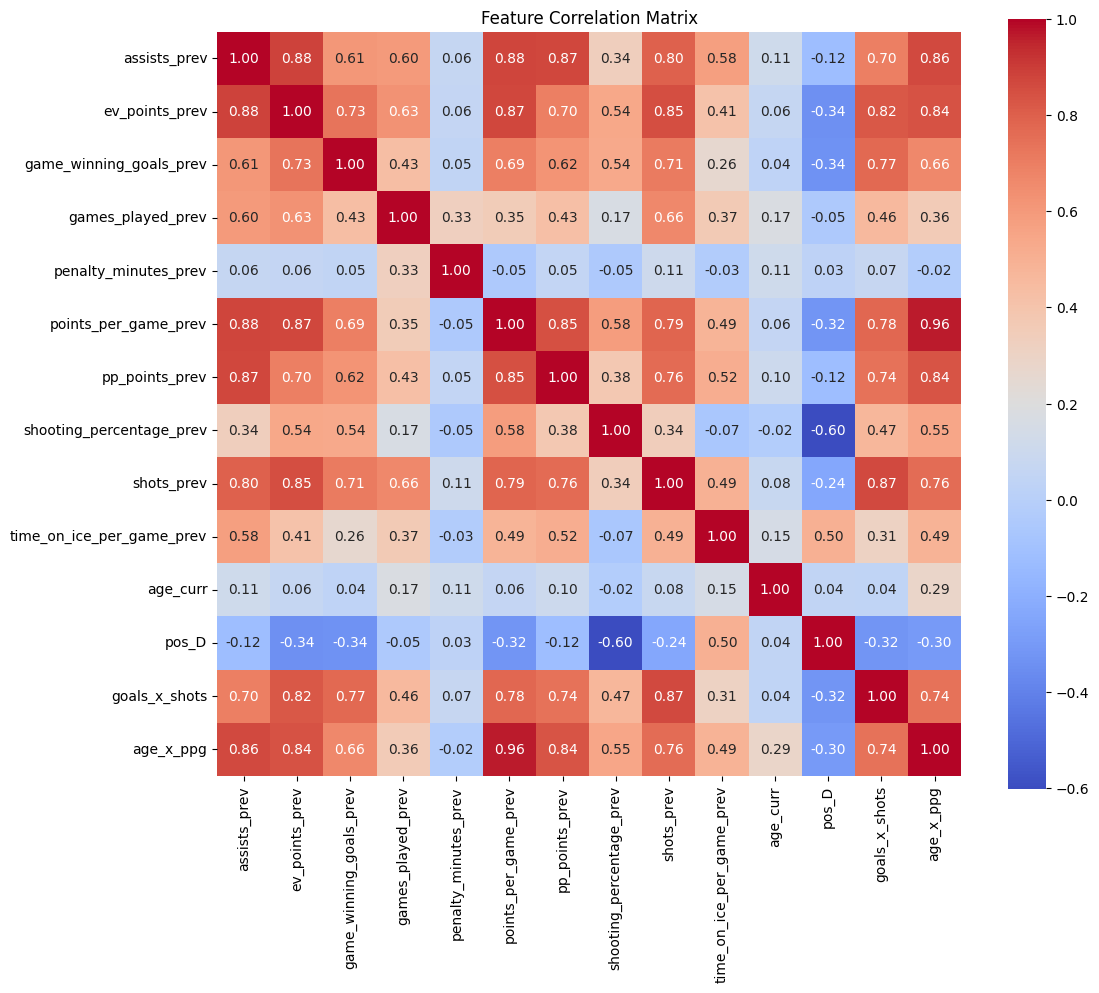

In [433]:
#check for coorrelation between features
corr_matrix = players_df[features].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.show()

In [434]:
X = players_df[features]
y = players_df["points_per_game_curr"]

In [435]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    players_df_model[features], 
    players_df_model["points_per_game_curr"], 
    test_size=0.2, 
    random_state=42
)

# Add intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit OLS
model = sm.OLS(y_train, X_train_const).fit()

train_cols = X_train_const.columns.tolist()

# Predict on test set
y_pred = model.predict(X_test_const)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test R²: {r2:.2f}, RMSE: {rmse:.3f}")

# Combine coefficients and p-values
coeffs = pd.DataFrame({
    "feature": model.params.index,
    "coefficient": model.params.values,
    "p_value": model.pvalues.values
}).sort_values(by="coefficient", ascending=False)

coeffs_formatted = coeffs.copy()
coeffs_formatted["coefficient"] = coeffs_formatted["coefficient"].map("{:.5f}".format)
coeffs_formatted["p_value"] = coeffs_formatted["p_value"].map("{:.5f}".format)

print(coeffs_formatted)

#R²: 0.61, RMSE: 0.178

Test R²: 0.74, RMSE: 0.137
                      feature coefficient  p_value
6        points_per_game_prev     0.75420  0.00000
0                       const     0.20185  0.00000
7              pp_points_prev     0.00500  0.00000
2              ev_points_prev     0.00327  0.00001
3     game_winning_goals_prev     0.00322  0.00252
9                  shots_prev     0.00043  0.00000
10  time_on_ice_per_game_prev     0.00013  0.00000
13              goals_x_shots    -0.00001  0.00001
5        penalty_minutes_prev    -0.00016  0.00009
4           games_played_prev    -0.00102  0.00000
1                assists_prev    -0.00293  0.00002
11                   age_curr    -0.00406  0.00000
14                  age_x_ppg    -0.00545  0.00001
12                      pos_D    -0.09111  0.00000
8    shooting_percentage_prev    -0.50873  0.00000


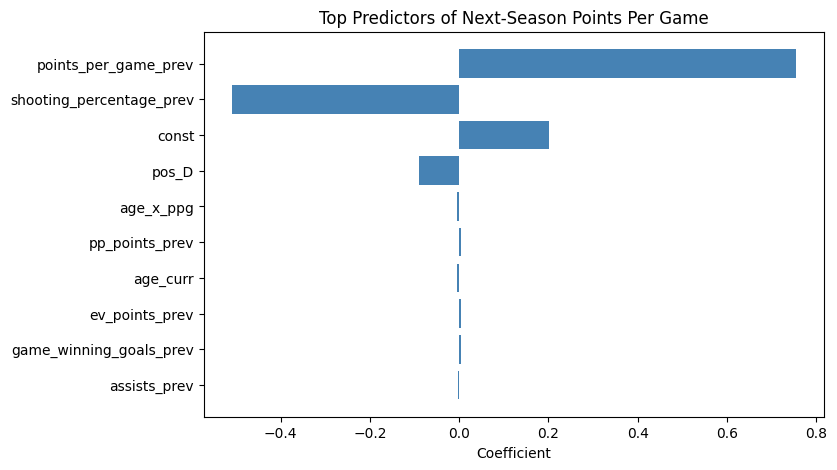

In [436]:
top_coeffs = coeffs.copy()
top_coeffs["coefficient"] = top_coeffs["coefficient"].astype(float)
top_coeffs = top_coeffs.reindex(top_coeffs["coefficient"].abs().sort_values(ascending=False).index)[:10]

plt.figure(figsize=(8,5))
plt.barh(top_coeffs["feature"], top_coeffs["coefficient"], color="steelblue")
plt.xlabel("Coefficient")
plt.title("Top Predictors of Next-Season Points Per Game")
plt.gca().invert_yaxis()
plt.show()

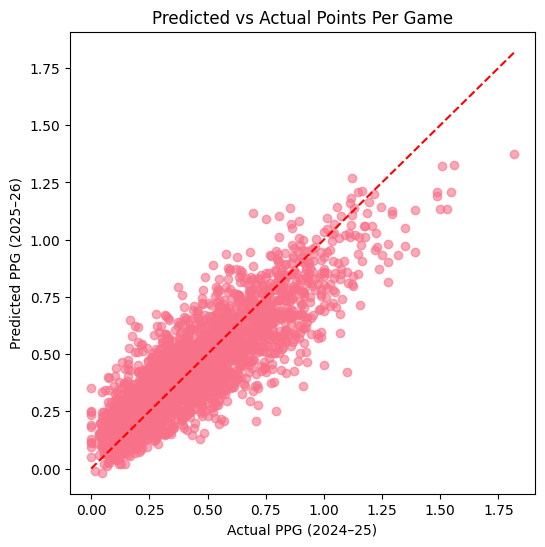

In [437]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual PPG (2024–25)")
plt.ylabel("Predicted PPG (2025–26)")
plt.title("Predicted vs Actual Points Per Game")
plt.show()

In [438]:
#select a couple players to compare actual vs predicted
sample_players = X_test.sample(5, random_state=42)

sample_players_const = sm.add_constant(sample_players)

sample_predictions = model.predict(sample_players_const)
print("Sample Player Predictions:")
for player_id, actual, predicted in zip(sample_players.index, y_test.loc[sample_players.index], sample_predictions):
    player_name = players_df.loc[player_id, 'last_name_prev']
    print(f"Player ID: {players_df.loc[player_id, 'player_id']}, Name: {player_name}, Actual PPG: {actual:.3f}, Predicted PPG: {predicted:.3f}")
# Combine coefficients and p-values
coeffs = pd.DataFrame({
    "feature": model.params.index,
    "coefficient": model.params.values,
    "p_value": model.pvalues.values
}).sort_values(by="coefficient", ascending=False)


Sample Player Predictions:
Player ID: 8469455, Name: Spezza, Actual PPG: 0.397, Predicted PPG: 0.345
Player ID: 8480762, Name: Robinson, Actual PPG: 0.213, Predicted PPG: 0.332
Player ID: 8465025, Name: Asham, Actual PPG: 0.263, Predicted PPG: 0.175
Player ID: 8479458, Name: Zaitsev, Actual PPG: 0.309, Predicted PPG: 0.252
Player ID: 8476892, Name: Parayko, Actual PPG: 0.377, Predicted PPG: 0.473


In [439]:
#for all players in players_df with the most recent season_id_prev as 20242025, predict their points_per_game_curr of the upcoming season

upcoming_season_players = players_df[players_df['season_id_prev'] == 20242025]
upcoming_season_X = upcoming_season_players[features]
upcoming_season_X_const = sm.add_constant(upcoming_season_X, has_constant='add')

upcoming_season_predictions = model.predict(upcoming_season_X_const)
print("Upcoming Season Predictions:")
for player_id, predicted in zip(upcoming_season_players.index, upcoming_season_predictions):
    player_name = upcoming_season_players.loc[player_id, 'last_name_prev']
    print(f"Player ID: {upcoming_season_players.loc[player_id, 'player_id']}, Name: {player_name}, Predicted PPG (2025–26): {predicted:.3f}")



Upcoming Season Predictions:
Player ID: 8470613, Name: Burns, Predicted PPG (2025–26): 0.292
Player ID: 8471214, Name: Ovechkin, Predicted PPG (2025–26): 0.826
Player ID: 8471215, Name: Malkin, Predicted PPG (2025–26): 0.578
Player ID: 8471675, Name: Crosby, Predicted PPG (2025–26): 0.915
Player ID: 8471685, Name: Kopitar, Predicted PPG (2025–26): 0.658
Player ID: 8471724, Name: Letang, Predicted PPG (2025–26): 0.360
Player ID: 8471817, Name: Reaves, Predicted PPG (2025–26): 0.103
Player ID: 8473419, Name: Marchand, Predicted PPG (2025–26): 0.615
Player ID: 8473422, Name: Foligno, Predicted PPG (2025–26): 0.349
Player ID: 8473507, Name: Petry, Predicted PPG (2025–26): 0.165
Player ID: 8473512, Name: Giroux, Predicted PPG (2025–26): 0.541
Player ID: 8473533, Name: Staal, Predicted PPG (2025–26): 0.356
Player ID: 8473986, Name: Killorn, Predicted PPG (2025–26): 0.403
Player ID: 8474013, Name: Cole, Predicted PPG (2025–26): 0.164
Player ID: 8474102, Name: Perron, Predicted PPG (2025–26): 

In [440]:
#this doesn't account for playing on multiple teams (those are 2 different rows)
#biased against top players for decreases
#biased for players who played few games previously

upcoming_season_players = upcoming_season_players.copy()
upcoming_season_players['predicted_points_per_game_curr'] = upcoming_season_predictions
#remove players with games_played_prev less than 20
upcoming_season_players = upcoming_season_players[upcoming_season_players['games_played_prev'] >= 20]
upcoming_season_players['points_per_game_change'] = upcoming_season_players['predicted_points_per_game_curr'] - upcoming_season_players['points_per_game_prev']
top_increases = upcoming_season_players.nlargest(10, 'points_per_game_change')
top_decreases = upcoming_season_players.nsmallest(10, 'points_per_game_change')

print("Top 10 Players with Biggest Predicted PPG Increases for 2025–26:")
for idx, row in top_increases.iterrows():
    print(f"Player ID: {row['player_id']}, Name: {row['last_name_prev']}, Previous PPG: {row['points_per_game_prev']:.3f}, Predicted PPG (2025–26): {row['predicted_points_per_game_curr']:.3f}, Change: {row['points_per_game_change']:.3f}")

print("\nTop 10 Players with Biggest Predicted PPG Decreases for 2025–26:")
for idx, row in top_decreases.iterrows():
    print(f"Player ID: {row['player_id']}, Name: {row['last_name_prev']}, Previous PPG: {row['points_per_game_prev']:.3f}, Predicted PPG (2025–26): {row['predicted_points_per_game_curr']:.3f}, Change: {row['points_per_game_change']:.3f}")

Top 10 Players with Biggest Predicted PPG Increases for 2025–26:
Player ID: 8482775, Name: Kapanen, Previous PPG: 0.143, Predicted PPG (2025–26): 0.270, Change: 0.128
Player ID: 8478468, Name: Lauzon, Previous PPG: 0.036, Predicted PPG (2025–26): 0.132, Change: 0.097
Player ID: 8483499, Name: Ohgren, Previous PPG: 0.208, Predicted PPG (2025–26): 0.302, Change: 0.093
Player ID: 8480848, Name: Dellandrea, Previous PPG: 0.118, Predicted PPG (2025–26): 0.198, Change: 0.081
Player ID: 8482702, Name: Stankoven, Previous PPG: 0.487, Predicted PPG (2025–26): 0.563, Change: 0.076
Player ID: 8480797, Name: Farabee, Previous PPG: 0.309, Predicted PPG (2025–26): 0.382, Change: 0.074
Player ID: 8483476, Name: Lekkerimäki, Previous PPG: 0.250, Predicted PPG (2025–26): 0.323, Change: 0.073
Player ID: 8483468, Name: Kulich, Previous PPG: 0.387, Predicted PPG (2025–26): 0.458, Change: 0.071
Player ID: 8483489, Name: Minten, Previous PPG: 0.238, Predicted PPG (2025–26): 0.308, Change: 0.070
Player ID: 8